In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Q1 web scrapping data from wikipedia

In [2]:
# Fetch the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

In [3]:
# Find the table with the list of S&P 500 companies
table = soup.find("table", {"id": "constituents"})

In [4]:
# Extract the rows
rows = table.find_all("tr")[1:]  # Skip the header row

In [5]:
# Extract relevant data
data = []
for row in rows:
    cols = row.find_all("td")
    ticker = cols[0].text.strip()
    name = cols[1].text.strip()
    date_added = cols[5].text.strip() if len(cols) > 6 else ""
    year_added = date_added.split("-")[0] if date_added else ""
    data.append([ticker, name, year_added])

# Create DataFrame
df = pd.DataFrame(data, columns=["Ticker", "Name", "Year Added"])

In [6]:
# Count number of companies added per year (excluding empty year entries)
added_per_year = df[df["Year Added"] != ""].groupby("Year Added").size().reset_index(name="Number of Companies Added")

# Convert Year Added to integer for sorting
added_per_year["Year Added"] = added_per_year["Year Added"].astype(int)
added_per_year = added_per_year.sort_values("Number of Companies Added", ascending=False)

print(added_per_year)

    Year Added  Number of Companies Added
0         1957                         53
48        2017                         23
47        2016                         23
50        2019                         22
39        2008                         17
55        2024                         16
53        2022                         16
54        2023                         15
52        2021                         15
49        2018                         14
46        2015                         14
43        2012                         14
28        1997                         14
33        2002                         13
40        2009                         12
38        2007                         12
51        2020                         12
9         1976                         11
29        1998                         11
44        2013                         10
42        2011                         10
37        2006                         10
41        2010                    

# Q2 Indexes YTD

In [7]:
import pandas as pd
import yfinance as yf

In [8]:
# Define the tickers and country labels
indices = {
    "United States - S&P 500": "^GSPC",
    "China - Shanghai Composite": "000001.SS",
    "Hong Kong - HANG SENG INDEX": "^HSI",
    "Australia - S&P/ASX 200": "^AXJO",
    "India - Nifty 50": "^NSEI",
    "Canada - S&P/TSX Composite": "^GSPTSE",
    "Germany - DAX": "^GDAXI",
    "United Kingdom - FTSE 100": "^FTSE",
    "Japan - Nikkei 225": "^N225",
    "Mexico - IPC Mexico": "^MXX",
    "Brazil - Ibovespa": "^BVSP"
}

# Set the date range
start_date = "2025-01-01"
end_date = "2025-05-01"

# Collect YTD performance data
performance_data = {}

for name, ticker in indices.items():
    ticker_obj = yf.Ticker(ticker)
    hist = ticker_obj.history(start=start_date, end=end_date)
    if not hist.empty:
        start_price = hist["Close"].iloc[0]
        end_price = hist["Close"].iloc[-1]
        ytd_change = ((end_price - start_price) / start_price) * 100
        performance_data[name] = ytd_change
    else:
        performance_data[name] = None  # or NaN, depending on your needs

# Convert to DataFrame
ytd_performance_df = pd.DataFrame.from_dict(performance_data, orient='index', columns=["YTD % Change"])
ytd_performance_df.index.name = "Index"
ytd_performance_df = ytd_performance_df.sort_values(by="YTD % Change", ascending=False)

# Display the YTD performance data
print(ytd_performance_df)


                             YTD % Change
Index                                    
Mexico - IPC Mexico             13.049444
Hong Kong - HANG SENG INDEX     12.720018
Brazil - Ibovespa               12.438710
Germany - DAX                   12.346378
United Kingdom - FTSE 100        2.842590
India - Nifty 50                 2.490424
China - Shanghai Composite       0.504817
Canada - S&P/TSX Composite      -0.226126
Australia - S&P/ASX 200         -0.914500
United States - S&P 500         -5.103301
Japan - Nikkei 225              -8.297931


# Q3 S&P 500 Market Corrections Analysis

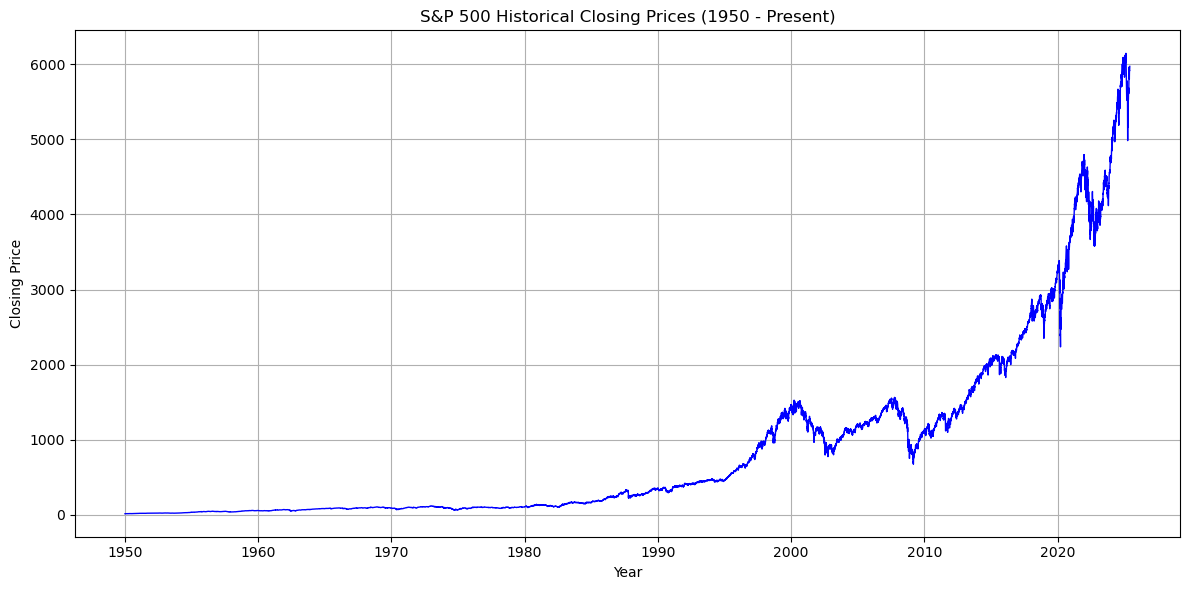

In [9]:
# Define the ticker for S&P 500
ticker = "^GSPC"

# Download historical data (from 1950 to present) using yf.Ticker().history()
ticker_obj = yf.Ticker(ticker)
data = ticker_obj.history(start="1950-01-01")  # end=None means up to the present

# Plot the 'Close' price as a simple line chart
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["Close"], color="blue", linewidth=1)
plt.title("S&P 500 Historical Closing Prices (1950 - Present)")
plt.xlabel("Year")
plt.ylabel("Closing Price")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Identify all-time high points
data["AllTimeHigh"] = data["Close"] > data["Close"].cummax().shift(1).fillna(0)

# convert Date index to datetime if not already
data.index = pd.to_datetime(data.index).date

# Filter for all-time highs
all_time_highs = data[data["AllTimeHigh"]]

# Reset index to access row positions
ath_dates = all_time_highs.index.to_list()



In [11]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,AllTimeHigh
1950-01-03,16.66,16.66,16.66,16.66,1260000,0.0,0.0,True
1950-01-04,16.85,16.85,16.85,16.85,1890000,0.0,0.0,True
1950-01-05,16.93,16.93,16.93,16.93,2550000,0.0,0.0,True
1950-01-06,16.98,16.98,16.98,16.98,2010000,0.0,0.0,True
1950-01-09,17.08,17.08,17.08,17.08,2520000,0.0,0.0,True


In [12]:
# Store results: (ATH1_date, ATH1_price, min_date, min_price, ATH2_date, ATH2_price, drawdown, duration)
ath_pairs = []

for i in range(len(ath_dates) - 1):
    start = ath_dates[i]
    end = ath_dates[i + 1]
    
    # Get all rows between two ATHs, exclusive
    mask = (data.index > start) & (data.index < end)
    between = data.loc[mask]
    
    if not between.empty:
        min_idx = between["Close"].idxmin()
        min_price = between.loc[min_idx, "Close"]
        
        # Get the ATH1 and ATH2 prices
        ath1_price = data.loc[start, "Close"]
        ath2_price = data.loc[end, "Close"]
        
        # Calculate drawdown percentage
        drawdown_pct = ((ath1_price - min_price) / ath1_price) * 100
        
        # Calculate duration in days from ATH1 to Min_date
        correction_duration_days = (min_idx - start).days
        
        ath_pairs.append({
            "ATH1_date": start,
            "ATH1_price": ath1_price,
            "Min_date": min_idx,
            "Min_price": min_price,
            "ATH2_date": end,
            "ATH2_price": ath2_price,
            "Drawdown_pct": drawdown_pct,
            "Correction_duration_days": correction_duration_days
        })

# Convert to DataFrame
ath_pairs_df = pd.DataFrame(ath_pairs)

# Filter for drawdowns larger than 5%
ath_pairs_filtered = ath_pairs_df[ath_pairs_df["Drawdown_pct"] > 5]

# Calculate percentiles of the correction durations
percentiles = ath_pairs_filtered["Correction_duration_days"].quantile([0.25, 0.5, 0.75])

# Display results
print("Filtered ATH pairs:\n", ath_pairs_filtered.head(10))
print("\nCorrection duration percentiles (days):")
print(percentiles)




Filtered ATH pairs:
      ATH1_date  ATH1_price    Min_date  Min_price   ATH2_date  ATH2_price  \
15  1950-06-12   19.400000  1950-07-17  16.680000  1950-09-22   19.440001   
20  1950-11-24   20.320000  1950-12-04  19.000000  1950-12-28   20.379999   
28  1951-05-03   22.809999  1951-06-29  20.959999  1951-08-02   22.820000   
34  1951-10-15   23.850000  1951-11-23  22.400000  1952-01-03   23.879999   
37  1952-01-22   24.660000  1952-02-20  23.090000  1952-06-26   24.750000   
43  1952-08-08   25.549999  1952-10-22  23.799999  1952-11-28   25.660000   
50  1953-01-05   26.660000  1953-09-14  22.709999  1954-03-11   26.690001   
80  1955-01-03   36.750000  1955-01-17  34.580002  1955-02-04   36.959999   
83  1955-03-04   37.520000  1955-03-14  34.959999  1955-04-12   37.660000   
94  1955-09-23   45.630001  1955-10-11  40.799999  1955-11-14   46.410000   

    Drawdown_pct  Correction_duration_days  
15     14.020615                        35  
20      6.496062                        1

In [13]:
ath_pairs_filtered.sort_values(by="Drawdown_pct", ascending=False, inplace=True)
ath_pairs_filtered.head(15)


C:\Users\HAOZHENG\AppData\Local\Temp\ipykernel_1340\1845895146.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ath_pairs_filtered.sort_values(by="Drawdown_pct", ascending=False, inplace=True)


,ATH1_date,ATH1_price,Min_date,Min_price,ATH2_date,ATH2_price,Drawdown_pct,Correction_duration_days
454,2007-10-09,1565.150024,2009-03-09,676.530029,2013-03-28,1569.189941,56.775388,517
449,2000-03-24,1527.459961,2002-10-09,776.760010,2007-05-30,1530.229980,49.146948,929
212,1973-01-11,120.239998,1974-10-03,62.279999,1980-07-17,121.440002,48.203593,630
199,1968-11-29,108.370003,1970-05-26,69.290001,1972-03-06,108.769997,36.061641,543
580,2020-02-19,3386.149902,2020-03-23,2237.399902,2020-08-18,3389.780029,33.924960,33
298,1987-08-25,336.769989,1987-12-04,223.919998,1989-07-26,338.049988,33.509515,101
137,1961-12-12,72.639999,1962-06-26,52.320000,1963-09-03,72.660004,27.973568,196
225,1980-11-28,140.520004,1982-08-12,102.419998,1982-11-03,142.869995,27.113582,622
626,2022-01-03,4796.560059,2022-10-12,3577.030029,2024-01-19,4839.810059,25.425097,282
182,1966-02-09,94.059998,1966-10-07,73.199997,1967-05-04,94.320000,22.177335,240


In [14]:
# Store results: (ATH1_date, min_date, min_price, ATH2_date)
# ath_pairs = []

# for i in range(len(ath_dates) - 1):
#     start = ath_dates[i]
#     end = ath_dates[i + 1]
#     if (end - start).days > 1:
#         between = data.loc[start:end].iloc[1:-1]
#         if not between.empty:
#             min_row = between["Close"].idxmin()
#             min_price = between.loc[min_row, "Close"]
#             ath_pairs.append({
#                 "ATH1_date": start,
#                 "ATH2_date": end,
#                 "Min_date": min_date,
#                 "Min_price": min_price
#             })

# # Convert to DataFrame for display
# ath_pairs_df = pd.DataFrame(ath_pairs)
# ath_pairs_df.head(10)

# Question 4. Earnings Surprise Analysis for Amazon (AMZN)

In [15]:
import pandas as pd
import re
import yfinance as yf
#pip install yfinance


In [35]:

# Use the RAW GitHub URL, not the HTML page link
url = "https://raw.githubusercontent.com/Haoshka/stock-markets-analytics-zoomcamp/refs/heads/main/cohorts/2025/ha1_Amazon.csv"

# Load into a DataFrame
amazondf = pd.read_csv(url,sep=";")

# Show first few rows
print(amazondf.head(5))

  Symbol           Company                 Earnings Date EPS Estimate  \
0   AMZN    Amazon.com Inc    April 29, 2026 at 6 AM EDT            -   
1   AMZN    Amazon.com Inc  February 4, 2026 at 4 PM EST            -   
2   AMZN    Amazon.com Inc  October 29, 2025 at 6 AM EDT            -   
3   AMZN    Amazon.com Inc     July 30, 2025 at 4 PM EDT            -   
4   AMZN  Amazon.com, Inc.       May 1, 2025 at 4 PM EDT       ???.36   

  Reported EPS Surprise (%)  
0            -            -  
1            -            -  
2            -            -  
3            -            -  
4       ???.59       +16.74  


In [ ]:
# normalize the column names - not necessary but good practice
# amazondf["Company"] = amazondf["Company"].str.replace(",", " ").str.strip()

In [36]:
# extract date only from Earnings Date
amazondf["Earnings Date"] = amazondf["Earnings Date"].apply(
    lambda x: " ".join(x.split(" ")[:3]) if isinstance(x, str) else x
)
amazondf["Earnings Date"] = pd.to_datetime(amazondf["Earnings Date"])


In [37]:
# Clean EPS columns — fix '???' patterns
def clean_eps(value):
    if pd.isna(value) or not isinstance(value, str):
        return value
    value = re.sub(r"\?\?\?\.([0-9]+)", r"1.\1", value)    # '???.xx' → '1.xx'
    value = re.sub(r"([0-9]+)\.\?\?\?", r"\1.03", value)    # 'xx.???' → 'xx.03'
    return value

amazondf["EPS Estimate"] = amazondf["EPS Estimate"].apply(clean_eps)
amazondf["Reported EPS"] = amazondf["Reported EPS"].apply(clean_eps)

In [38]:
amazondf.head(5)

,Symbol,Company,Earnings Date,EPS Estimate,Reported EPS,Surprise (%)
0,AMZN,Amazon.com Inc,2026-04-29,-,-,-
1,AMZN,Amazon.com Inc,2026-02-04,-,-,-
2,AMZN,Amazon.com Inc,2025-10-29,-,-,-
3,AMZN,Amazon.com Inc,2025-07-30,-,-,-
4,AMZN,"Amazon.com, Inc.",2025-05-01,1.36,1.59,+16.74


In [39]:
#Remove '+' in Surprise (%) and convert to float
amazondf["Surprise (%)"] = amazondf["Surprise (%)"].str.replace("+", "", regex=False)




#Convert EPS and Surprise columns to numeric (float → then int if needed)
for col in ["EPS Estimate", "Reported EPS", "Surprise (%)"]:
    amazondf[col] = pd.to_numeric(amazondf[col], errors="coerce")





amazondf.dropna(subset=["EPS Estimate", "Reported EPS","Surprise (%)"], inplace=True, how="all")
amazondf.reset_index(drop=True, inplace=True)

In [40]:
amazondf.head(5)

,Symbol,Company,Earnings Date,EPS Estimate,Reported EPS,Surprise (%)
0,AMZN,"Amazon.com, Inc.",2025-05-01,1.36,1.59,16.74
1,AMZN,"Amazon.com, Inc.",2025-02-06,1.49,1.86,24.47
2,AMZN,"Amazon.com, Inc.",2024-10-31,1.14,1.43,25.17
3,AMZN,"Amazon.com, Inc.",2024-08-01,1.03,1.26,22.58
4,AMZN,"Amazon.com, Inc.",2024-04-30,0.83,0.98,17.91


In [41]:
# Define the ticker
ticker = "AMZN"

# Download complete historical data
amznyf_df = yf.download(ticker, start="1990-01-01", progress=False)


In [42]:
amznyf_df = amznyf_df["Close"].copy().reset_index(drop=False)
amznyf_df.columns = ["Date", "Close"]


In [43]:
amznyf_df["2 Day Change"] = (amznyf_df["Close"].shift(-2) / amznyf_df["Close"] - 1) * 100


In [44]:
amznyf_df.head(5)

,Date,Close,2 Day Change
0,1997-05-15,0.097917,-12.765910
1,1997-05-16,0.086458,-5.421125
2,1997-05-19,0.085417,-16.463936
3,1997-05-20,0.081771,-14.649446
4,1997-05-21,0.071354,5.109736


In [45]:
amazondf = amazondf[amazondf["EPS Estimate"] < amazondf["Reported EPS"] ]

In [47]:
amazondf.shape

(37, 6)

In [48]:
merged_df = amazondf.merge(amznyf_df, left_on="Earnings Date", right_on="Date", how="left")
merged_df.drop(columns=["Date", "Close"], inplace=True)

In [51]:
merged_df.shape

(37, 7)

In [52]:
merged_df["2 Day Change"].median()

1.9663313467461307

In [53]:
amznyf_df["2 Day Change"].median()

0.16581674487468057